In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sn_name = 'SN2012fr'
sn_name

'SN2012fr'

In [3]:
sn_files = glob.glob(sn_name + '*.dat')
sn_files

['SN2012fr19.dat',
 'SN2012fr2.dat',
 'SN2012fr10.dat',
 'SN2012fr3.dat',
 'SN2012fr0.dat',
 'SN2012fr4.dat',
 'SN2012fr7.dat',
 'SN2012fr1.dat',
 'SN2012fr17.dat',
 'SN2012fr16.dat',
 'SN2012fr13.dat',
 'SN2012fr15.dat',
 'SN2012fr5.dat',
 'SN2012fr12.dat',
 'SN2012fr11.dat',
 'SN2012fr18.dat',
 'SN2012fr14.dat',
 'SN2012fr9.dat',
 'SN2012fr6.dat',
 'SN2012fr8.dat']

In [4]:
spec_time = []
for i in range(0, len(sn_files)):
    
    file = open(sn_files[i])
    lines = file.readlines()
    file.close()
    
    time_temp = lines[0]
    time_temp = time_temp[:-1]
    time_temp = float(time_temp[1:])
    
    spec_time.append(time_temp)

In [5]:
spec_time

[1.8897951064267506,
 11.836085140244135,
 45.653471255223245,
 53.61050328227716,
 21.78237517406152,
 -3.083349910481942,
 5.868311119953705,
 -8.056494927390634,
 35.70718122140586,
 9.846827133480659,
 2.884424109808489,
 -7.061865924008896,
 69.52456733638498,
 -1.094091903718465,
 7.857569126717181,
 -5.072607917245419,
 28.74477819773369,
 61.56753530933106,
 15.81460115377109,
 32.723294211260644]

In [16]:
# wave grid
wave_grid = np.linspace(3000, 9000, 200 + 1)

# spliting our data to compare
sn_train = spec_time[-1:]
#spec_time_train = spec_time[1::]

# our data array
data = []
spec_time_train = []
for i in range(0, len(wave_grid)):
    
    data.append([])
    spec_time_train.append([])

# select our training data
for i in range(0, len(sn_train)):
    
    flux = []
    
    file = open(sn_files[i])
    lines = file.readlines()
    file.close()
    
    #time of the spectra
    time_temp = lines[0]
    time_temp = time_temp[:-1]
    time_temp = float(time_temp[1:])
    
    for line in lines:
        if line.startswith('#'): continue
        co=line.rstrip().replace('INDEF','Nan').split()

        #flux values
        flux.append(float(co[1]))
    
    
    for j in range(0, len(flux)):
        
        if flux[j] > 10**(-64):
            data[j].append(flux[j])
            spec_time_train[j].append(time_temp)

In [17]:
#plt.plot(spec_time_train[150], data[150], 'k.')
#plt.xlabel('time (days)')
#plt.ylabel('flux (erg/s/$\AA$/cm^2)'); # be carefull! not exacly in this unit

In [18]:
# import gaussian process library
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

#define a kernel
kernel = 0.5 * (RBF(length_scale=5, length_scale_bounds=(1, 10)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

In [19]:
#fit our splitted data
X_ = np.array([spec_time[0]])
#X_ = np.linspace(-10, 50, 60 + 1)

In [20]:
fitted_model_wave = []
fitted_model_flux = []
fitted_model_flux_un = []

In [21]:
for n in range(0, len(spec_time_train)):
    
    # number of data must be greater than 4
    if len(spec_time_train[n]) > 4:

        X_train = []
        #sk-learn format 
        for i in range(0, len(spec_time_train[n])):

            X_train.append([spec_time_train[n][i]])

        y_train = data[n]

        factor = max(y_train)
        y_train = np.array(y_train)/factor # normalize to fit

        
        # gaussian process and its prediction
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X_train, y_train)
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True) 
        
        #print(max(y_mean))
        fitted_model_wave.append(wave_grid[n])
        fitted_model_flux.append(y_mean[0]*factor)
        fitted_model_flux_un.append(np.sqrt(np.diag(y_cov))[0]*factor)

In [22]:
# real data

real_spec_x = []
real_spec_y = []

file = open(sn_files[0])
lines = file.readlines()
file.close()
    
for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()

    #flux values
    real_spec_x.append(float(co[0]))
    real_spec_y.append(float(co[1]))
    

In [13]:
# difference between them
from scipy.interpolate import interp1d

interp_real = interp1d(real_spec_x, real_spec_y)
interp_sintetic = interp1d(fitted_model_wave, fitted_model_flux)

diff = lambda x: abs((interp_real(x) - interp_sintetic(x)) / interp_real(x))
plot_grid = np.linspace(3500, 8000, 200 + 1)

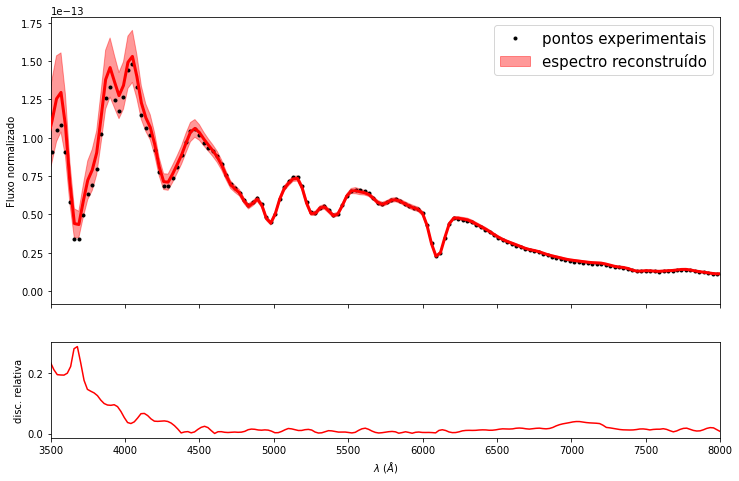

In [14]:
figure, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(12,8))
plt.rcParams.update({"font.size": 15})

axes[0].fill_between(fitted_model_wave, np.array(fitted_model_flux) + np.array(fitted_model_flux_un),  np.array(fitted_model_flux) - np.array(fitted_model_flux_un), alpha=0.4, color='r', label='espectro reconstruído')
axes[0].plot(fitted_model_wave, np.array(fitted_model_flux), 'r', lw=3, zorder=9)
axes[0].plot(real_spec_x, real_spec_y, 'k.', label='pontos experimentais')
axes[0].set_yticklabels([])
#axes[0].set_xlabel('wavelenght ($\AA$)')
axes[0].set_ylabel('Fluxo normalizado')
axes[0].legend(loc="upper right")
axes[0].set_xlim(3500, 8000)

axes[1].plot(plot_grid, diff(plot_grid), color = 'r')

axes[1].set_xlabel('$\lambda$ ($\AA$)')
axes[1].set_ylabel('disc. relativa')
plt.subplots_adjust(bottom=0.15)

figure.savefig('/home/joao/Desktop/SN2012fr_t_32_7.png', dpi=200)

In [15]:
diff(plot_grid) > 0.2

array([ True,  True, False, False, False,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,